# Npower Final Project

In [237]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Importing Dataset

### Import data from https://www.kaggle.com/datasets/bushraqurban/tourism-and-economic-impact

In [238]:
# Import the kagglehub library to programmatically download datasets from Kaggle
import kagglehub

# Download the latest version of the "insurance" dataset by mirichoi0218
# This returns the local path where the dataset was saved
path = kagglehub.dataset_download("bushraqurban/tourism-and-economic-impact")

# Print the path to confirm where the dataset was downloaded
print("Path to dataset files:", path)

# Load the insurance.csv file into a pandas DataFrame
df = pd.read_csv(path + "/world_tourism_economy_data.csv")

Path to dataset files: C:\Users\anmol\.cache\kagglehub\datasets\bushraqurban\tourism-and-economic-impact\versions\1


# Data Wrangling

### 1. Inspecting the data

In [239]:
df.head()

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,7.820000e+08,9.720000e+05,62.542949,NaN,9.495387,1.722905e+09,2.280372,NaN
1,Africa Eastern and Southern,AFE,1999,8.034209e+09,1.530938e+07,12.204030,NaN,7.760536,2.654293e+11,7.819865,NaN
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1999,1.443613e+09,3.897975e+06,3.974476,NaN,6.147291,1.394683e+11,0.372266,NaN
4,Angola,AGO,1999,3.100000e+07,4.500000e+04,0.583858,NaN,2.489638,6.152923e+09,248.195902,NaN


In [240]:
df.tail()

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
6645,Kosovo,XKX,2023,NaN,NaN,NaN,NaN,NaN,1.046822e+10,4.944324,NaN
6646,"Yemen, Rep.",YEM,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6647,South Africa,ZAF,2023,NaN,NaN,NaN,NaN,NaN,3.806993e+11,6.073909,32.098
6648,Zambia,ZMB,2023,NaN,NaN,NaN,NaN,NaN,2.757796e+10,10.884532,NaN
6649,Zimbabwe,ZWE,2023,NaN,NaN,NaN,NaN,NaN,3.523137e+10,NaN,9.348


In [241]:
df.describe()

,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
count,6650.000000,4.289000e+03,4.949000e+03,4114.000000,2.589000e+03,4173.000000,6.424000e+03,5668.000000,3658.000000
mean,2011.000000,3.062956e+10,6.263894e+07,15.506851,8.246093e+07,6.652740,2.089999e+12,6.319369,7.961191
std,7.211645,1.291076e+11,2.049444e+08,17.758374,2.064665e+08,4.071632,7.761985e+12,18.682769,5.802565
min,1999.000000,1.000000e+05,9.000000e+02,0.000956,2.000000e+03,0.157818,1.396473e+07,-16.859691,0.039000
25%,2005.000000,2.690000e+08,5.290000e+05,4.657732,1.051000e+06,4.074702,6.087182e+09,1.865425,4.250000
50%,2011.000000,1.553000e+09,2.508000e+06,8.306797,4.634000e+06,5.754790,3.681803e+10,3.629433,6.548000
75%,2017.000000,9.144227e+09,1.818000e+07,18.506710,4.508703e+07,7.985102,4.266977e+11,6.563197,9.894692
max,2023.000000,1.863069e+12,2.403074e+09,101.966999,2.034432e+09,28.192276,1.061717e+14,557.201817,57.000000


In [242]:
df.describe(include='object')

,country,country_code
count,6650,6650
unique,266,266
top,Zimbabwe,ZWE
freq,25,25


In [243]:
df.dtypes

country                  object
country_code             object
year                      int64
tourism_receipts        float64
tourism_arrivals        float64
tourism_exports         float64
tourism_departures      float64
tourism_expenditures    float64
gdp                     float64
inflation               float64
unemployment            float64
dtype: object

### 2. Handling Duplicates

In [244]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print("Duplicates:", duplicate_count)

Duplicates: 0


#### Therefore, there are no duplicates in dataset

### 3. Convert Data Types

In [245]:
# Convert the 'year' column to a Period with yearly frequency
df['year'] = df['year'].astype(str).astype('period[Y]')

In [246]:
# Display the converted column
print(df['year'].head())

0    1999
1    1999
2    1999
3    1999
4    1999
Name: year, dtype: period[Y-DEC]


### 4. Data Cleaning

In [248]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

In [249]:
df[numeric_cols].isnull().sum()

tourism_receipts        2361
tourism_arrivals        1701
tourism_exports         2536
tourism_departures      4061
tourism_expenditures    2477
gdp                      226
inflation                982
unemployment            2992
dtype: int64

In [251]:
# Step 1: For each numeric column, group by 'country_code' and fill NaN with the group (country-specific) mean.
df[numeric_cols] = df.groupby('country_code')[numeric_cols].transform(
    lambda x: x.fillna(x.mean())
)

In [252]:
df[numeric_cols].isnull().sum()

tourism_receipts         775
tourism_arrivals         425
tourism_exports          775
tourism_departures      2875
tourism_expenditures     725
gdp                      100
inflation                650
unemployment             625
dtype: int64

In [253]:
# Step 2: Now, for any group where all values were NaN (and so the mean was NaN), fill those remaining NaNs with 0.
df[numeric_cols] = df[numeric_cols].fillna(0)

In [254]:
# Check the results
print("Missing values per column after imputation:")
print(df.isnull().sum())

Missing values per column after imputation:
country                 0
country_code            0
year                    0
tourism_receipts        0
tourism_arrivals        0
tourism_exports         0
tourism_departures      0
tourism_expenditures    0
gdp                     0
inflation               0
unemployment            0
dtype: int64


### 5. Final Check

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype        
---  ------                --------------  -----        
 0   country               6650 non-null   object       
 1   country_code          6650 non-null   object       
 2   year                  6650 non-null   period[Y-DEC]
 3   tourism_receipts      6650 non-null   float64      
 4   tourism_arrivals      6650 non-null   float64      
 5   tourism_exports       6650 non-null   float64      
 6   tourism_departures    6650 non-null   float64      
 7   tourism_expenditures  6650 non-null   float64      
 8   gdp                   6650 non-null   float64      
 9   inflation             6650 non-null   float64      
 10  unemployment          6650 non-null   float64      
dtypes: float64(8), object(2), period[Y-DEC](1)
memory usage: 571.6+ KB


In [256]:
df.head()

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,7.820000e+08,9.720000e+05,62.542949,0.0,9.495387,1.722905e+09,2.280372,7.806000
1,Africa Eastern and Southern,AFE,1999,8.034209e+09,1.530938e+07,12.204030,0.0,7.760536,2.654293e+11,7.819865,0.000000
2,Afghanistan,AFG,1999,9.992308e+07,0.000000e+00,5.486974,0.0,1.750260,1.326544e+10,6.124620,6.779167
3,Africa Western and Central,AFW,1999,1.443613e+09,3.897975e+06,3.974476,0.0,6.147291,1.394683e+11,0.372266,5.385473
4,Angola,AGO,1999,3.100000e+07,4.500000e+04,0.583858,0.0,2.489638,6.152923e+09,248.195902,13.642857


# Exploratory Data Analysis

### Univariate and Bivariate Analysis

#### Univariate Analysis:

In [257]:
# Since year column represents only annual data, here we explore its range and distribution.
df['year'].value_counts().sort_index()

year
1999    266
2000    266
2001    266
2002    266
2003    266
2004    266
2005    266
2006    266
2007    266
2008    266
2009    266
2010    266
2011    266
2012    266
2013    266
2014    266
2015    266
2016    266
2017    266
2018    266
2019    266
2020    266
2021    266
2022    266
2023    266
Freq: Y-DEC, Name: count, dtype: int64

In [258]:
# Checking frequency of each country
df['country_code'].value_counts()

country_code
ZWE    25
ABW    25
AFE    25
AFG    25
AFW    25
       ..
AUT    25
AUS    25
ATG    25
ASM    25
ARM    25
Name: count, Length: 266, dtype: int64

#### Bivariate Analysis:

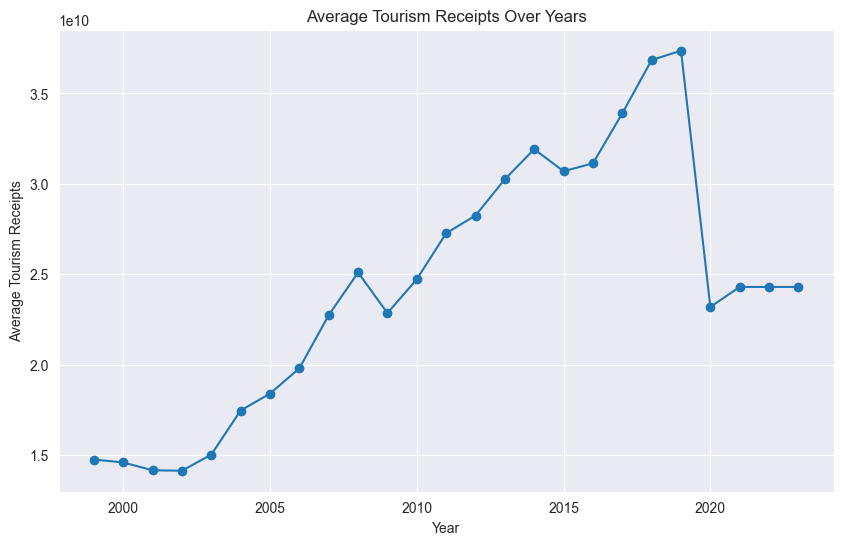

In [259]:
# Tourism Receipts over Time:
yearly_trend = df.groupby(df['year'].dt.year)['tourism_receipts'].mean()
yearly_trend.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average Tourism Receipts Over Years')
plt.xlabel('Year')
plt.ylabel('Average Tourism Receipts')
plt.show()

### Correlation and Additional Numeric Analysis

In [260]:
# Correlation Matrix
corr_matrix = df[numeric_cols].corr()
corr_matrix

,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
tourism_receipts,1.000000,0.871571,-0.076940,0.858707,-0.002173,0.853772,-0.035000,-0.023745
tourism_arrivals,0.871571,1.000000,-0.107232,0.980820,-0.014175,0.930723,-0.042521,-0.035418
tourism_exports,-0.076940,-0.107232,1.000000,-0.107767,0.354713,-0.106664,-0.054461,0.075028
tourism_departures,0.858707,0.980820,-0.107767,1.000000,-0.018868,0.940426,-0.038129,-0.038501
tourism_expenditures,-0.002173,-0.014175,0.354713,-0.018868,1.000000,-0.015486,0.009318,0.073656
gdp,0.853772,0.930723,-0.106664,0.940426,-0.015486,1.000000,-0.038663,-0.052039
inflation,-0.035000,-0.042521,-0.054461,-0.038129,0.009318,-0.038663,1.000000,0.012860
unemployment,-0.023745,-0.035418,0.075028,-0.038501,0.073656,-0.052039,0.012860,1.000000


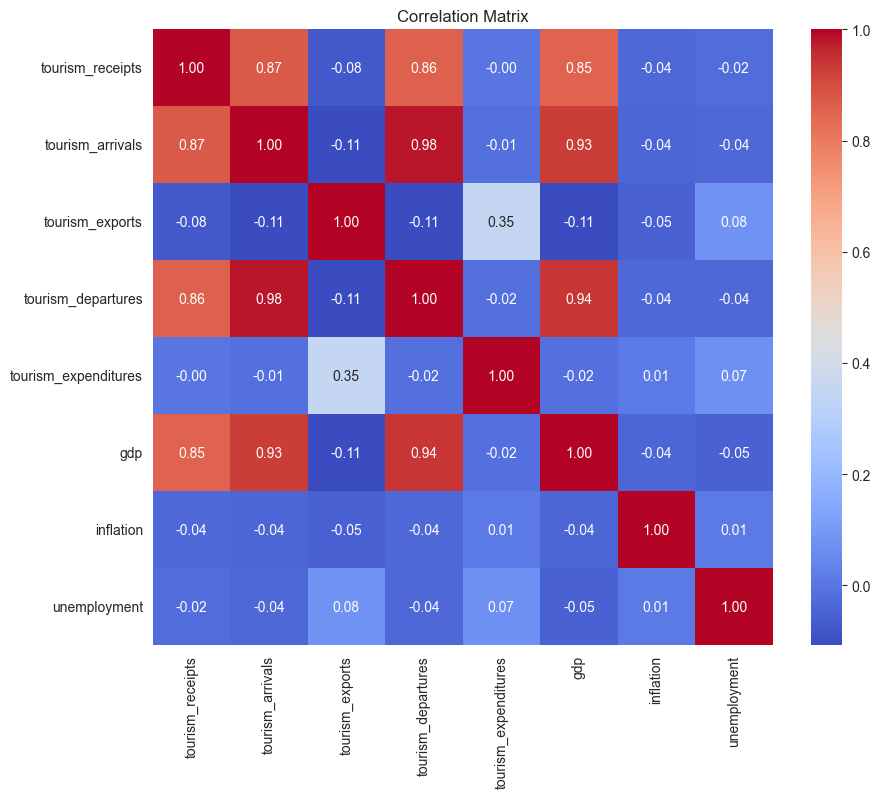

In [261]:
# Heatmap of Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Regression Plot

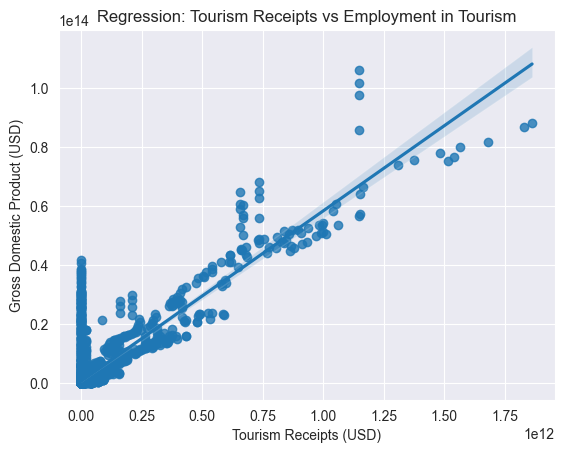

In [262]:
# Regression plot between tourism receipts and Employment in tourism
sns.regplot(x='tourism_receipts', y='gdp', data=df)

plt.title('Regression: Tourism Receipts vs Employment in Tourism')
plt.xlabel('Tourism Receipts (USD)')
plt.ylabel('Gross Domestic Product (USD)')
plt.show()

### Textual Data Exploration

In [263]:
# Preparing the text data
text_data = df['country_code'] + df['country']
text = " ".join(text_data.astype(str))

In [264]:
# Generating word cloud
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)

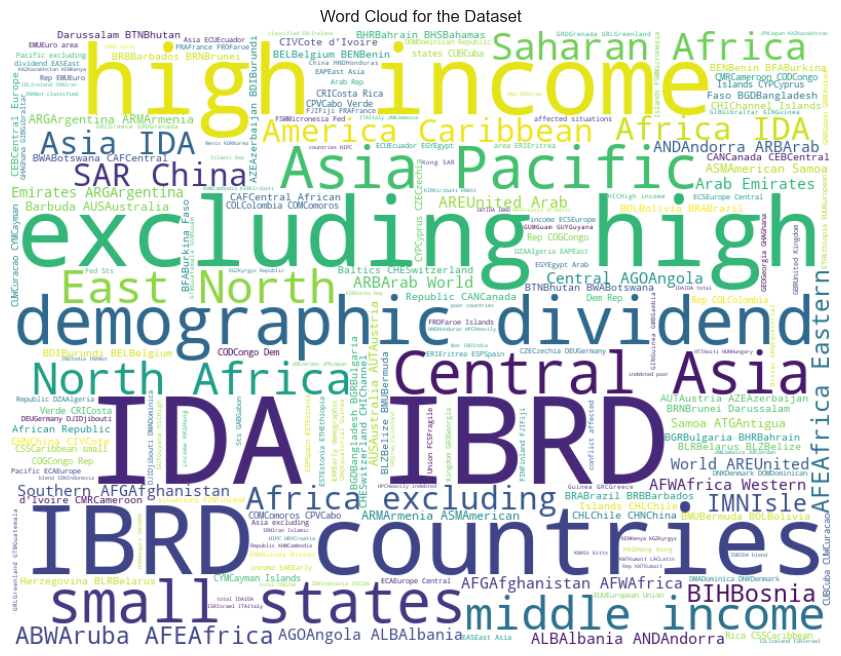

In [265]:
# Plot the word cloud using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the Dataset')
plt.show()

# Bar Chart

In [266]:
import pycountry

# Create a list of country names using list comprehension
country_names = [country.name for country in pycountry.countries]

In [267]:
# Print the list of country names
print(country_names)

['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Åland Islands', 'Albania', 'Andorra', 'United Arab Emirates', 'Argentina', 'Armenia', 'American Samoa', 'Antarctica', 'French Southern Territories', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Bonaire, Sint Eustatius and Saba', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina', 'Saint Barthélemy', 'Belarus', 'Belize', 'Bermuda', 'Bolivia, Plurinational State of', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Bouvet Island', 'Botswana', 'Central African Republic', 'Canada', 'Cocos (Keeling) Islands', 'Switzerland', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon', 'Congo, The Democratic Republic of the', 'Congo', 'Cook Islands', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Curaçao', 'Christmas Island', 'Cayman Islands', 'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egy

In [268]:
# Filtered entries
df_filtered = df[df["country"].isin(country_names)]

In [269]:
# Group by 'country_code' and sum up the 'tourism_receipts'
grouped_receipts = df_filtered.groupby('country')['tourism_receipts'].sum()

In [270]:
# Sort the results in descending order and select the top 10 countries
top10_countries = grouped_receipts.sort_values(ascending=False).head(10)

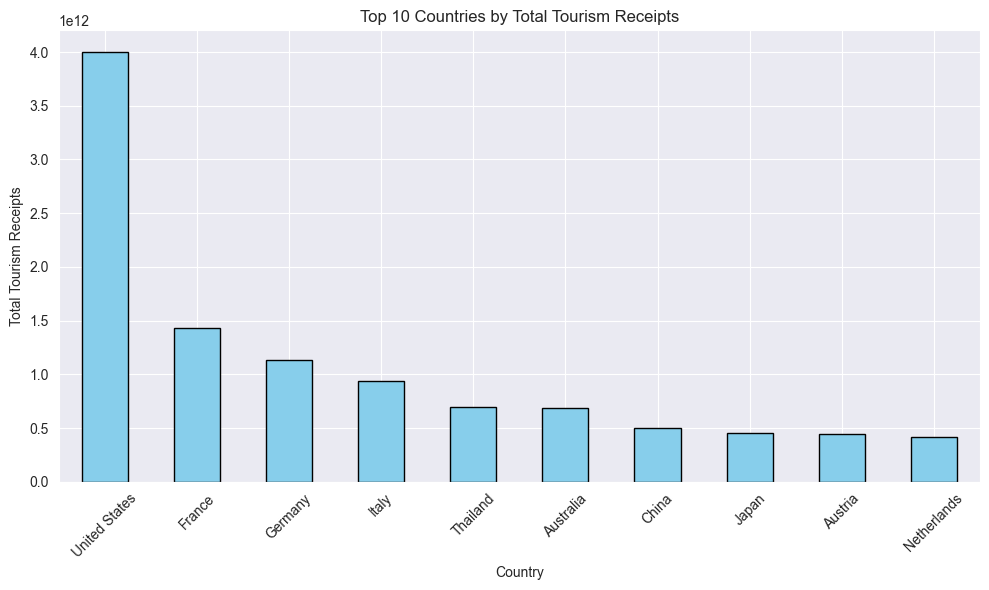

In [271]:
# Create a bar chart
plt.figure(figsize=(10, 6))
top10_countries.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Countries by Total Tourism Receipts')
plt.xlabel('Country')
plt.ylabel('Total Tourism Receipts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grouped Bar Chart

In [272]:
# Grouping by country (using filtered dataset) and summing the three metrics
df_top10 = (df_filtered.groupby('country')[['tourism_receipts', 'gdp', 'tourism_arrivals']].sum().sort_values(by='tourism_receipts', ascending=False).head(10))

<Figure size 1200x800 with 0 Axes>

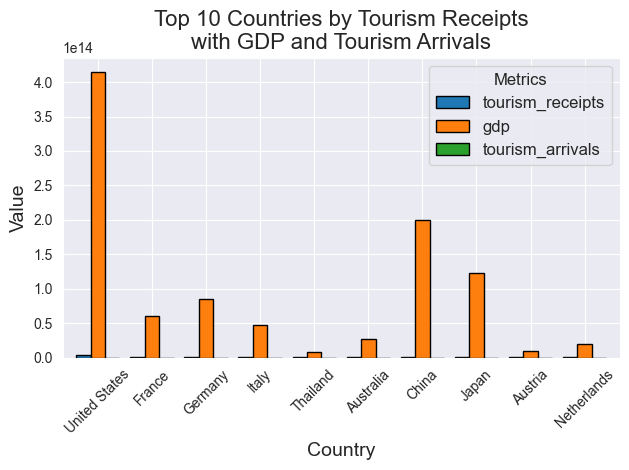

In [273]:
plt.figure(figsize=(12,8))
df_top10.plot(kind='bar', width=0.8, edgecolor='black')

plt.title('Top 10 Countries by Tourism Receipts\nwith GDP and Tourism Arrivals', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Metrics', fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()

# Dashboard

In [274]:
# Import necessary libraries
import io
import base64
from dash import Dash, html, dcc

In [275]:
# Helper function: convert a Matplotlib figure to a base64-encoded PNG image.
def fig_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    encoded = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)  # release memory
    return "data:image/png;base64,{}".format(encoded)

In [276]:
# Create options for the drop-down based on unique country codes from the dataset.
# (Adjust this if your country column uses full country names.)
country_options = [{'label': c, 'value': c} for c in sorted(df['country_code'].unique())]


In [277]:
# Initialize the Dash app
app = Dash(__name__)

# Define the layout: A drop-down at the top, followed by tabs (each with a chart).
app.layout = html.Div([
    html.H1("Tourism Economy Interactive Dashboard", style={'textAlign': 'center'}),

    # Drop-down to select countries (multi-select enabled)
    html.Div([
        dcc.Dropdown(
            id='country-dropdown',
            options=country_options,
            multi=True,
            placeholder="Select countries (Default shows top 10 by Tourism Receipts)"
        )
    ], style={'width': '50%', 'margin': 'auto', 'padding': '20px 0'}),

    # Tabs for three chart types
    dcc.Tabs([
        dcc.Tab(label='Pie Chart', children=[
            html.Div([
                html.H3("Distribution of Tourism Receipts", style={'textAlign': 'center'}),
                html.Img(id='pie-chart', style={'display': 'block', 'margin': 'auto', 'width': '80%'})
            ])
        ]),
        dcc.Tab(label='Bar Chart', children=[
            html.Div([
                html.H3("Top Countries by Tourism Receipts", style={'textAlign': 'center'}),
                html.Img(id='bar-chart', style={'display': 'block', 'margin': 'auto', 'width': '80%'})
            ])
        ]),
        dcc.Tab(label='Grouped Bar Chart', children=[
            html.Div([
                html.H3("Metrics Comparison (Tourism Receipts, GDP, Tourism Arrivals)",
                        style={'textAlign': 'center'}),
                html.Img(id='grouped-bar-chart', style={'display': 'block', 'margin': 'auto', 'width': '80%'})
            ])
        ])
    ])
])

# Callback: update all three charts when the drop-down selection changes.
@app.callback(
    Output('pie-chart', 'src'),
    Output('bar-chart', 'src'),
    Output('grouped-bar-chart', 'src'),
    Input('country-dropdown', 'value')
)
def update_charts(selected_countries):
    # Determine which data subset to use:
    # If no countries are selected, default to using the entire dataset
    # and use the top 10 countries based on total tourism receipts.
    if not selected_countries:
        df_filtered = df.copy()
        # Group and sum tourism receipts per country then take top 10.
        grouped_receipts = (df_filtered.groupby('country_code')['tourism_receipts']
                            .sum()
                            .sort_values(ascending=False)
                            .head(10))
    else:
        # Filter the dataset for the selected countries
        df_filtered = df[df['country_code'].isin(selected_countries)]
        # Group and sum tourism receipts.
        grouped_receipts = (df_filtered.groupby('country_code')['tourism_receipts']
                            .sum()
                            .sort_values(ascending=False))
        # In case more than 10 countries are selected, show only the top 10.
        if len(grouped_receipts) > 10:
            grouped_receipts = grouped_receipts.head(10)

    # ---- PIE CHART ----
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    ax1.pie(grouped_receipts, labels=grouped_receipts.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title("Distribution of Tourism Receipts")
    ax1.axis('equal')  # Make sure pie is drawn as a circle.
    pie_chart_img = fig_to_base64(fig1)

    # ---- BAR CHART ----
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    grouped_receipts.plot(kind='bar', ax=ax2, color='skyblue', edgecolor='black')
    ax2.set_title("Top Countries by Tourism Receipts")
    ax2.set_xlabel("Country")
    ax2.set_ylabel("Total Tourism Receipts")
    ax2.tick_params(axis='x', rotation=45)
    bar_chart_img = fig_to_base64(fig2)

    # ---- GROUPED BAR CHART ----
    # For the grouped bar chart, we compare multiple metrics.
    # Filter (or use full dataset if no drop-down selection) and group by country.
    if not selected_countries:
        df_group = df.copy()
    else:
        df_group = df[df['country_code'].isin(selected_countries)]

    grouped_metrics = (df_group.groupby('country_code')[['tourism_receipts', 'gdp', 'tourism_arrivals']]
                       .sum()
                       .sort_values(by='tourism_receipts', ascending=False))
    if len(grouped_metrics) > 10:
        grouped_metrics = grouped_metrics.head(10)

    fig3, ax3 = plt.subplots(figsize=(12, 8))
    grouped_metrics.plot(kind='bar', ax=ax3, width=0.8, edgecolor='black')
    ax3.set_title("Comparison of Tourism Receipts, GDP, and Tourism Arrivals")
    ax3.set_xlabel("Country")
    ax3.set_ylabel("Value")
    ax3.tick_params(axis='x', rotation=45)
    grouped_bar_chart_img = fig_to_base64(fig3)

    # Return the base64 images to update each chart component.
    return pie_chart_img, bar_chart_img, grouped_bar_chart_img

# Run the app
if __name__ == '__main__':
    app.run(debug=True)